In [1]:
import collections
import csv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

#### Loading the data...

In [2]:
algorithm = 'louvain' 

In [3]:
representatives_df = pd.read_csv("../../data/raw_data/twitter_representatives_handles_final.csv")

##### Loading retweet networks

In [4]:
# loading the networks since we need to get the
# indegree of each representative
# Reading data
basepath = '../../data/network_data'

before_data = pd.read_csv(os.path.join(basepath, 'before_campaign_representative.graph'))
during_data = pd.read_csv(os.path.join(basepath, 'campaign_representative.graph'))
after_data = pd.read_csv(os.path.join(basepath, 'after_elections_representative.graph'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape)

Before data has shape:  (72716, 3)
During data has shape:  (92920, 3)
After data has shape:  (91749, 3)


In [5]:
# Creating graphs
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

Before graph has:  34863  nodes and  72716  edges
During graph has:  46388  nodes and  92920  edges
After graph has:  66500  nodes and  91749  edges


##### Loading community data

In [7]:
output_path = f"../../results/{algorithm}_communities"

before_comms = pickle.load(open(os.path.join(output_path, 'before_comms.pickle'), 'rb'))
during_comms = pickle.load(open(os.path.join(output_path, 'during_comms.pickle'), 'rb'))
after_comms = pickle.load(open(os.path.join(output_path, 'after_comms.pickle'), 'rb'))

In [8]:
print("Before graph has: ", len(before_comms), " communities")
print("During graph has: ", len(during_comms), " communities")
print("After graph has: ", len(after_comms), " communities")

Before graph has:  9  communities
During graph has:  15  communities
After graph has:  17  communities


In [9]:
# size check
before_comm_sizes = [len(comm) for comm in before_comms]
during_comm_sizes = [len(comm) for comm in during_comms]
after_comm_sizes = [len(comm) for comm in after_comms]

In [10]:
print(np.quantile(before_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))
print(np.quantile(during_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))
print(np.quantile(after_comm_sizes, [0.25, 0.5, 0.75, .8, .9]))

[ 640.  4444.  5698.  5998.4 7018. ]
[2.00000e+00 3.00000e+00 5.31600e+03 6.46080e+03 1.10146e+04]
[2.0000e+00 5.0000e+00 3.1110e+03 6.0926e+03 7.3412e+03]


In [11]:
# get the number of communities in the .8 quantile
# this is not needed when dealing with undirected graphs
n_comm_b = len([comm for comm in before_comms if len(comm) >= 970])
n_comm_d = len([comm for comm in during_comms if len(comm) >= 252])
n_comm_a = len([comm for comm in after_comms if len(comm) >= 151])

print(n_comm_b, n_comm_d, n_comm_a)

6 6 5


#### Community analysis - Parties

##### Community entropy (in terms of parties/coalitions)

In [12]:
representatives_df.head(5);

In [13]:
parties, ids = representatives_df["Party"], representatives_df["ids"]

In [14]:
#get unique parties
unique_parties = list(set(parties))
print(len(unique_parties), unique_parties)

8 ['Movimento 5s', 'Azione - Italia Viva', 'Forza Italia', "Fratelli d'Italia", 'Noi moderati', 'Alleanza Verdi Sinistra', 'Lega', 'Partito Democratico']


In [15]:
# dict with key ids and parties as values
id2party = {ids[i]:parties[i] for i in range(0, len(ids))}

In [16]:
def eval_parties_composition(comm, id2party, count=False, weighted=False, retweet_net=None):
    to_return = []

    for user in comm:
        if user in id2party:
            if weighted:
                if retweet_net is None:
                    print('Need access to the network to get the indegree')
                    return None
                else:
                    indeg = retweet_net.in_degree(user, weight='weight')
                    to_return.append([id2party[user]]*max(indeg, 1))
            else:
                to_return.append(id2party[user])

    if count:
        return collections.Counter(to_return)

    if weighted:
        to_return = [party for weighted_party in to_return for party in weighted_party]

    return to_return

##### Get the party composition per community across the three periods

In [17]:
before_community_composition = {}
during_community_composition = {}
after_community_composition = {}

for index in range(0, len(before_comms)):
    before_community_composition[index] = eval_parties_composition(before_comms[index], id2party)

for index in range(0, len(during_comms)):
    during_community_composition[index] = eval_parties_composition(during_comms[index], id2party)

for index in range(0, len(after_comms)):
    after_community_composition[index] = eval_parties_composition(after_comms[index], id2party)


before_community_composition_w = {}
during_community_composition_w = {}
after_community_composition_w = {}

weighted = True

for index in range(0, len(before_comms)):
    before_community_composition_w[index] = \
        eval_parties_composition(before_comms[index], id2party, weighted=weighted, retweet_net=before_graph)

for index in range(0, len(during_comms)):
    during_community_composition_w[index] = \
        eval_parties_composition(during_comms[index], id2party, weighted=weighted, retweet_net=during_graph)

for index in range(0, len(after_comms)):
    after_community_composition_w[index] = \
        eval_parties_composition(after_comms[index], id2party, weighted=weighted, retweet_net=after_graph)

In [18]:
output_path = f"../../results/{algorithm}_communities/comms_composition"

#store the comms
pickle.dump(before_community_composition, open(os.path.join(output_path, 'before_community_composition.pickle'), 'wb'))
pickle.dump(during_community_composition, open(os.path.join(output_path, 'during_community_composition.pickle'), 'wb'))
pickle.dump(after_community_composition, open(os.path.join(output_path, 'after_community_composition.pickle'), 'wb'))

In [126]:
during_community_composition_w;

In [20]:
# get the different parties in each period
before_parties = {party for comm_comp in before_community_composition.values() for party in comm_comp}
during_parties = {party for comm_comp in during_community_composition.values() for party in comm_comp}
after_parties = {party for comm_comp in after_community_composition.values() for party in comm_comp}  

len(before_parties), len(during_parties), len(after_parties)

(8, 8, 8)

In [23]:
before_parties, during_parties, after_parties

({'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Noi moderati',
  'Partito Democratico'},
 {'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Noi moderati',
  'Partito Democratico'},
 {'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Noi moderati',
  'Partito Democratico'})

In [24]:
output_path = f"../../results/{algorithm}_communities/comms_composition"

#store the comms
pickle.dump(before_parties, open(os.path.join(output_path, 'before_parties.pickle'), 'wb'))
pickle.dump(during_parties, open(os.path.join(output_path, 'during_parties.pickle'), 'wb'))
pickle.dump(after_parties, open(os.path.join(output_path, 'after_parties.pickle'), 'wb'))

In [131]:
before_parties;

##### Plot the community composition

In [25]:
def get_values_to_plot(parties_per_period, comm_composition_per_period):
    ys = {}
    m = np.zeros([len(parties_per_period), len(comm_composition_per_period)])
    
    for (i, party) in enumerate(parties_per_period):
        ys[party] = []
        for (j, comm_comp) in enumerate(comm_composition_per_period):
            cnt = collections.Counter(comm_comp)
            if party in cnt:
                ys[party].append(cnt[party])
                m[i, j] = cnt[party]
            else:
                ys[party].append(0)
                m[i, j] = 0
    
    return ys, m.sum(axis=0)

In [26]:
def plot_party_dist_per_comm(ax, xs, parties_per_period, comm_composition_per_period):
    ys, tot_per_comm = get_values_to_plot(parties_per_period, comm_composition_per_period)
    # ys_val = list(ys.values()) / tot_per_comm
    sorted_parties = sorted(parties_per_period)

    #ys_val = [ys[party] for party in sorted_parties] / tot_per_comm
    num = np.array([ys[party] for party in sorted_parties], dtype=float)
    den = tot_per_comm
    
    ys_val = np.divide(num, den, out=np.zeros_like(num), where=den!=0)

    ax.bar(xs, ys_val[0], bottom=0)
    bottom = ys_val[0]

    for i in range(1, len(parties_per_period)):
        ax.bar(xs, ys_val[i], bottom=bottom)
        bottom += ys_val[i]

    legend = sorted_parties #list(ys.keys())
    ax.legend(legend, loc='upper center', ncol=len(list(ys.keys())), bbox_to_anchor=(0.5, 1.2))

    ax.set_xlabel("Communities")
    ax.set_ylabel("Party distribution")

    return ys

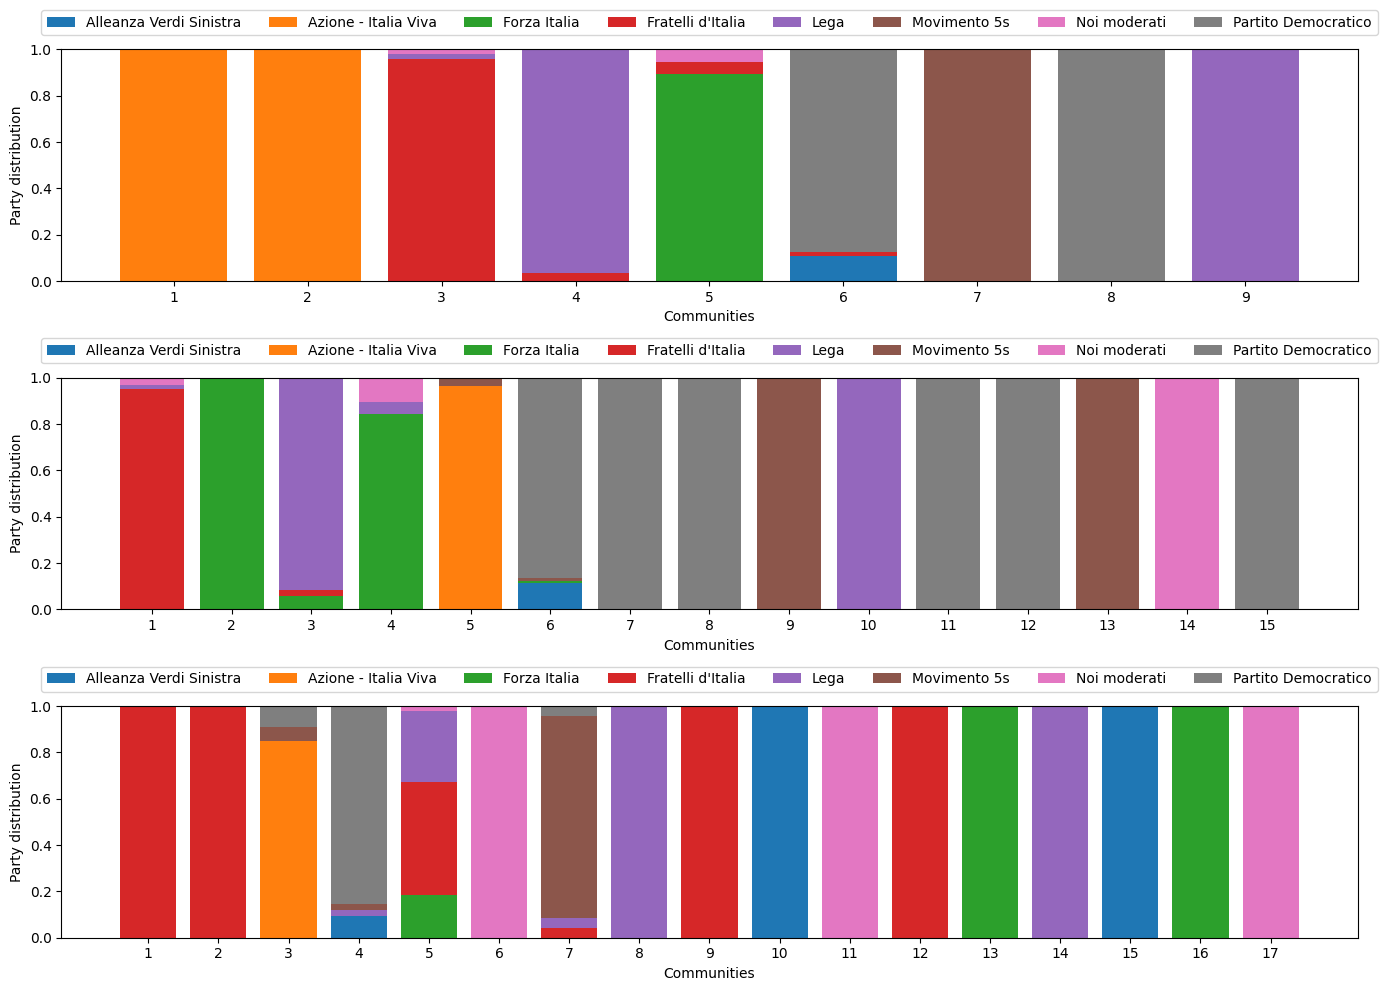

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

xs_b = [f"{i}" for i in range(1, len(before_comms)+1)]
xs_d = [f"{i}" for i in range(1, len(during_comms)+1)]
xs_a = [f"{i}" for i in range(1, len(after_comms)+1)]

# before 
plot_party_dist_per_comm(ax[0], xs_b, before_parties, before_community_composition.values())
# during
plot_party_dist_per_comm(ax[1], xs_d, during_parties, during_community_composition.values())
# after
plot_party_dist_per_comm(ax[2], xs_a, after_parties, after_community_composition.values())

fig.tight_layout()

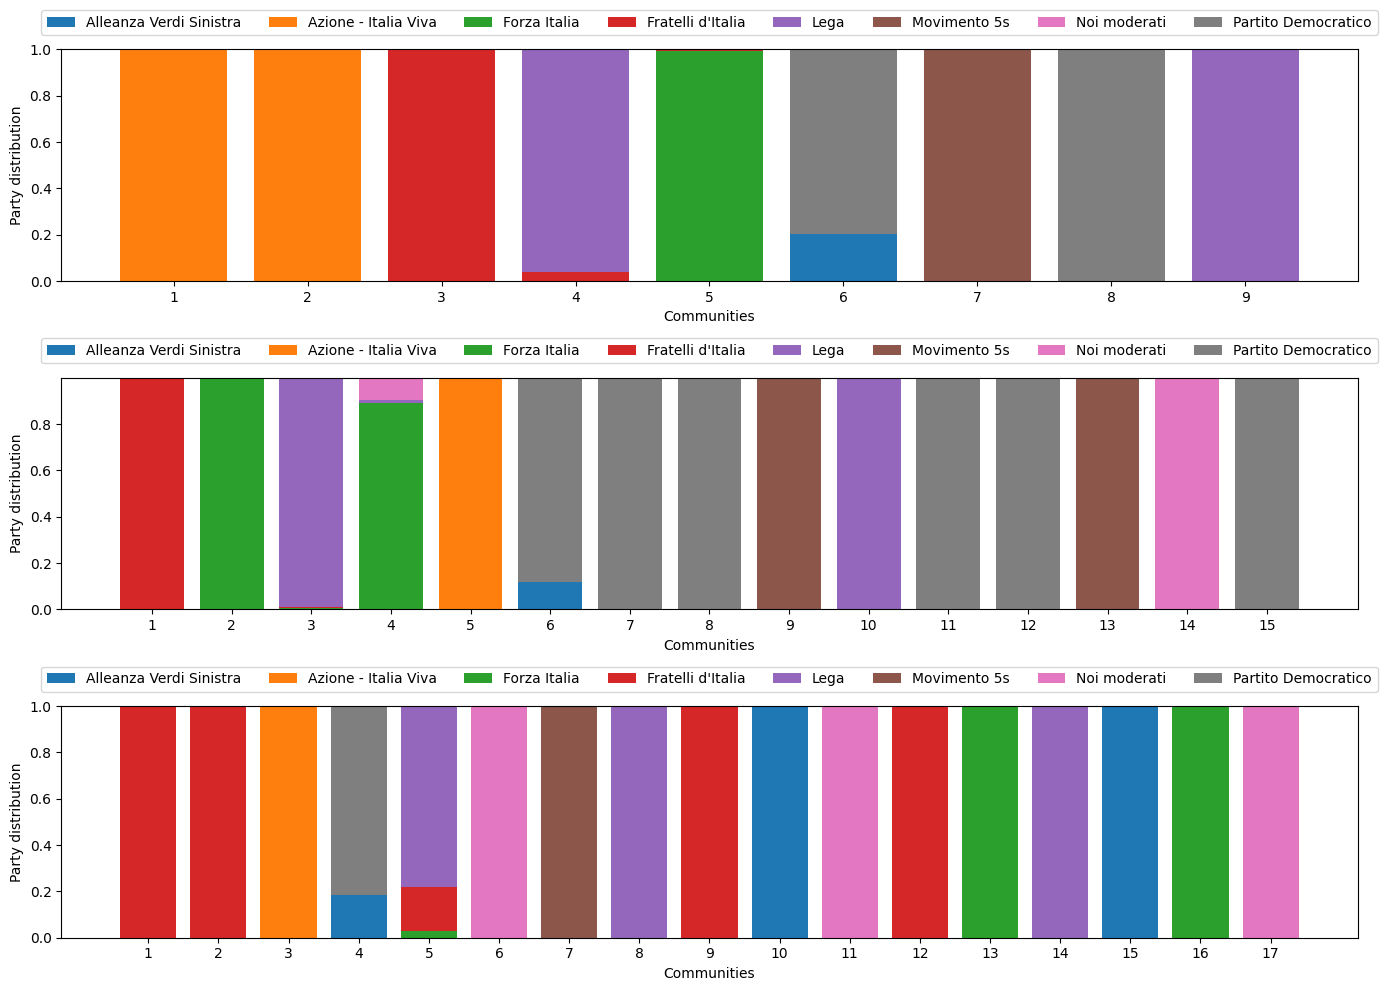

In [28]:
# weighted version where we take into account the indegree of each representative
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

xs_b = [f"{i}" for i in range(1, len(before_comms)+1)]
xs_d = [f"{i}" for i in range(1, len(during_comms)+1)]
xs_a = [f"{i}" for i in range(1, len(after_comms)+1)]

# before 
plot_party_dist_per_comm(ax[0], xs_b, before_parties, before_community_composition_w.values())
# during
plot_party_dist_per_comm(ax[1], xs_d, during_parties, during_community_composition_w.values())
# after
plot_party_dist_per_comm(ax[2], xs_a, after_parties, after_community_composition_w.values())

fig.tight_layout()

#### Community analysis - Representatives

In [29]:
# we want to know which candidate is in which community
def find_candidate(comm, representatives_df):
    to_return = []
    ids_representatives = representatives_df["ids"].values

    for user in comm:
        if user in ids_representatives:
            candidate_name = representatives_df[representatives_df["ids"] == user]["Name"].values[0]
            candidate_party = representatives_df[representatives_df["ids"] == user]["Party"].values[0]
            to_return.append((candidate_name, candidate_party))

    return to_return

In [30]:
candidates_per_comm_before = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(before_comms)}
candidates_per_comm_during = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(during_comms)}
candidates_per_comm_after = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(after_comms)}

In [31]:
candidates_per_comm_before

{0: [('Benzoni Fabrizio', 'Azione - Italia Viva'),
  ('Lombardo Marco', 'Azione - Italia Viva'),
  ('Pastorella Giulia', 'Azione - Italia Viva'),
  ('Ruffino Daniela', 'Azione - Italia Viva'),
  ('Carfagna Maria Rosaria', 'Azione - Italia Viva'),
  ('Gelmini Mariastella', 'Azione - Italia Viva'),
  ('Castiglione Giuseppe', 'Azione - Italia Viva'),
  ('Versace Giusy', 'Azione - Italia Viva'),
  ('Richetti Matteo', 'Azione - Italia Viva'),
  ('De Monte Isabella', 'Azione - Italia Viva'),
  ('Calenda Carlo', 'Azione - Italia Viva')],
 1: [('Marattin Luigi', 'Azione - Italia Viva'),
  ('Boschi Maria Elena', 'Azione - Italia Viva'),
  ('Rosato Ettore', 'Azione - Italia Viva'),
  ('Gadda Maria Chiara', 'Azione - Italia Viva'),
  ('Giachetti Roberto', 'Azione - Italia Viva'),
  ('Renzi Matteo', 'Azione - Italia Viva'),
  ('Faraone Davide', 'Azione - Italia Viva'),
  ('Costa Enrico', 'Azione - Italia Viva'),
  ('Paita Raffaella', 'Azione - Italia Viva'),
  ('Bonetti Elena', 'Azione - Italia Vi

In [32]:
candidates_per_comm_during

{0: [('Perissa Marco', "Fratelli d'Italia"),
  ('Osnato Marco', "Fratelli d'Italia"),
  ('Ciocchetti Luciano', "Fratelli d'Italia"),
  ('La Porta Chiara', "Fratelli d'Italia"),
  ('Mennuni Lavinia', "Fratelli d'Italia"),
  ('De Bertoldi Andrea', "Fratelli d'Italia"),
  ('Rotelli Mauro', "Fratelli d'Italia"),
  ('Russo Gaetana', "Fratelli d'Italia"),
  ('Fitto Raffaele', "Fratelli d'Italia"),
  ('Garavaglia Massimo', 'Lega'),
  ('Gardini Elisabetta', "Fratelli d'Italia"),
  ("Terzi Di Sant'Agata Giuliomaria", "Fratelli d'Italia"),
  ('Bignami Galeazzo', "Fratelli d'Italia"),
  ('Rosa Gianni', "Fratelli d'Italia"),
  ('Ciaburro Monica', "Fratelli d'Italia"),
  ('Lupi Maurizio', 'Noi moderati'),
  ('Garnero Santanchè Daniela', "Fratelli d'Italia"),
  ('Malan Lucio', "Fratelli d'Italia"),
  ('De Carlo Luca', "Fratelli d'Italia"),
  ('Gemmato Marcello', "Fratelli d'Italia"),
  ('Urso Adolfo', "Fratelli d'Italia"),
  ('Meloni Giorgia', "Fratelli d'Italia"),
  ('Berrino Gianni', "Fratelli d'I

In [33]:
candidates_per_comm_after

{0: [('Zaffini Francesco', "Fratelli d'Italia"),
  ('Lampis Gianni', "Fratelli d'Italia"),
  ('Speranzon Raffaele', "Fratelli d'Italia"),
  ('Meloni Giorgia', "Fratelli d'Italia")],
 1: [("Terzi Di Sant'Agata Giuliomaria", "Fratelli d'Italia")],
 2: [('Rosato Ettore', 'Azione - Italia Viva'),
  ('Renzi Matteo', 'Azione - Italia Viva'),
  ('Benzoni Fabrizio', 'Azione - Italia Viva'),
  ('Scalfarotto Ivan', 'Azione - Italia Viva'),
  ('Lombardo Marco', 'Azione - Italia Viva'),
  ('Grippo Valentina', 'Azione - Italia Viva'),
  ('Boschi Maria Elena', 'Azione - Italia Viva'),
  ('Sottanelli Giulio Cesare', 'Azione - Italia Viva'),
  ('Pastorella Giulia', 'Azione - Italia Viva'),
  ('Ruffino Daniela', 'Azione - Italia Viva'),
  ('Bonifazi Francesco', 'Azione - Italia Viva'),
  ('Carfagna Maria Rosaria', 'Azione - Italia Viva'),
  ('Gadda Maria Chiara', 'Azione - Italia Viva'),
  ('Giachetti Roberto', 'Azione - Italia Viva'),
  ('Gelmini Mariastella', 'Azione - Italia Viva'),
  ('Paita Raffae

#### Store communities' data

In [34]:
output_path = f'../../results/{algorithm}_communities/comms_composition_csv'

# we store the following data for each communtity. For each user,
# - the user id
# - the community they belong to
# - the most common party in the community

In [ ]:
when = 'after' # during after
dict_comms = {
    'before': before_comms,
    'during': during_comms,
    'after': after_comms
}
dict_composition = {
    'before': before_community_composition,
    'during': during_community_composition,
    'after': after_community_composition
}

communities = dict_comms[when]
communities_composition = dict_composition[when]
fout = open(os.path.join(output_path, f'{when}_communities.csv'), 'w')

with fout:
    writer = csv.writer(fout)
    writer.writerow(['user_id', 'community_id', 'most_common_party', 'all_parties'])

    for index in range(0, len(communities)):
        # get the community
        comm = communities[index]
        # get the parties in the community
        parties = communities_composition[index]

        if parties:
            # get the most common party
            most_common_party = collections.Counter(parties).most_common(1)[0][0]
        else:
            most_common_party = ""

        # get all parties
        parties = list(set(parties))
        parties_to_write = ";".join(parties)

        print(f"Community {index}, {len(comm)} users, {len(parties)} parties, most common party: {most_common_party}")

        for user in comm:
            writer.writerow([user, index, most_common_party, parties_to_write])

In [84]:
# BEFORE
# Community 0, 6449 users, 1 parties, most common party: Azione - Italia Viva
# Community 1, 4444 users, 1 parties, most common party: Azione - Italia Viva
# Community 2, 5698 users, 3 parties, most common party: Fratelli d'Italia
# Community 3, 4462 users, 2 parties, most common party: Lega
# Community 4, 640 users, 3 parties, most common party: Forza Italia
# Community 5, 9294 users, 3 parties, most common party: Partito Democratico
# Community 6, 3765 users, 1 parties, most common party: Movimento 5s
# Community 7, 109 users, 1 parties, most common party: Partito Democratico
# Community 8, 2 users, 1 parties, most common party: Lega

In [ ]:
# DURING
# Community 0, 13148 users, 3 parties, most common party: Fratelli d'Italia
# Community 1, 3 users, 1 parties, most common party: Forza Italia
# Community 2, 5414 users, 3 parties, most common party: Lega
# Community 3, 560 users, 3 parties, most common party: Forza Italia
# Community 4, 10648 users, 2 parties, most common party: Azione - Italia Viva
# Community 5, 11259 users, 4 parties, most common party: Partito Democratico
# Community 6, 123 users, 1 parties, most common party: Partito Democratico
# Community 7, 2 users, 1 parties, most common party: Partito Democratico
# Community 8, 5218 users, 1 parties, most common party: Movimento 5s
# Community 9, 2 users, 1 parties, most common party: Lega
# Community 10, 2 users, 1 parties, most common party: Partito Democratico
# Community 11, 2 users, 1 parties, most common party: Partito Democratico
# Community 12, 3 users, 1 parties, most common party: Movimento 5s
# Community 13, 2 users, 1 parties, most common party: Noi moderati
# Community 14, 2 users, 1 parties, most common party: Partito Democratico

In [ ]:
# AFTER
# Community 0, 41797 users, 1 parties, most common party: Fratelli d'Italia
# Community 1, 28 users, 1 parties, most common party: Fratelli d'Italia
# Community 2, 7340 users, 3 parties, most common party: Azione - Italia Viva
# Community 3, 7343 users, 4 parties, most common party: Partito Democratico
# Community 4, 6838 users, 4 parties, most common party: Fratelli d'Italia
# Community 5, 14 users, 1 parties, most common party: Noi moderati
# Community 6, 3111 users, 4 parties, most common party: Movimento 5s
# Community 7, 5 users, 1 parties, most common party: Lega
# Community 8, 2 users, 1 parties, most common party: Fratelli d'Italia
# Community 9, 2 users, 1 parties, most common party: Alleanza Verdi Sinistra
# Community 10, 4 users, 1 parties, most common party: Noi moderati
# Community 11, 2 users, 1 parties, most common party: Fratelli d'Italia
# Community 12, 2 users, 1 parties, most common party: Forza Italia
# Community 13, 2 users, 1 parties, most common party: Lega
# Community 14, 2 users, 1 parties, most common party: Alleanza Verdi Sinistra
# Community 15, 2 users, 1 parties, most common party: Forza Italia
# Community 16, 6 users, 1 parties, most common party: Noi moderati